In [1]:
from dimod import ExactSolver
import dwave.inspector
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
def visualize_sample(sampleset, sample_index=0):
    """
    Visualize a single sample from a D-Wave SampleSet in spin variables.

    Parameters:
        sampleset (dimod.SampleSet): The sample set containing spin samples.
        sample_index (int): Which sample in the set to visualize.
    """
    
    if sample_index >= len(sampleset):
        raise IndexError(f"Sample index {sample_index} out of range. SampleSet contains {len(sampleset)} samples.")
        
    sample = sampleset.record[sample_index].sample
    variables = sampleset.variables
    energy = sampleset.record.energy[sample_index]

    # Create graph for visualization.
    G = nx.Graph()
    
    # Add nodes with spin result. 
    for idx, var in enumerate(variables):
        spin = sample[idx]
        G.add_node(var, spin=spin)
        
    # Add edges based on coupling terms.
    for (u, v), coupling in J.items():
        G.add_edge(u, v, weight=coupling)

    pos = nx.circular_layout(G)
    colors = ['red' if G.nodes[n]['spin'] == 1 else 'blue' for n in G.nodes]
    labels = {n: f"{n}\n↑" if G.nodes[n]['spin'] == 1 else f"{n}\n↓" for n in G.nodes}

    nx.draw(G, pos, with_labels=True, labels=labels, node_color=colors, node_size=1200, font_size=14, font_color='white')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)

    plt.title(f"Sample {sample_index} | Energy: {energy:.2f}")

    plt.show()

In [3]:
def plot_energy_histogram(sampleset, bins=20):
    energies = sampleset.record.energy
    occurrences = sampleset.record.num_occurrences

    ylabel = "Occurrences"
    weights = occurrences
    title = f"Energy Histogram (num_reads = {sum(occurrences)})"
    color = 'skyblue'

    plt.hist(energies, weights=weights, bins=bins, color=color, edgecolor='black')
    plt.xlabel("Energy")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# A Simple Ising Problem

The Hamiltonian for the classical Ising problem reads

$$
 H_{\text{Ising}}(\boldsymbol{s}) = \sum_{i=1}^N h_i s_i + \sum_{i=1}^N \sum_{j=i+1}^N J_{ij}s_i s_j,
$$
with spin variables $s_i\in\{-1,+1\}$.
To find the lowest-energy state, we will consider 
$$
\min_{\boldsymbol{s}} H_{\text{Ising}}(\boldsymbol{s}). 
$$

In particular, we had
$$
    H_{\text{Ising}}(s_1, s_2, s_3) = 6 s_1 - 5 s_2 + 3 s_3 + 20 s_1 s_2 - 8 s_2 s_3 + 7 s_1 s_3,
$$
with biases $h_i$ and coupling strengths $J_{ij}$ as follows:
| i | $h_i$ |
|---|-------|
| 1 | 6 | 
| 2 |-5 | 
| 3 | 3 |

| i | j | $J_{ij}$ |
|---|---|----------|
| 1 | 2 | 20       | 
| 2 | 3 | -8       |
| 1 | 3 | 7        |

## The Problem Definition

To define the Ising problem, the coefficients $h_i$ and $J_{ij}$ can be provided via Python dictionaries:

`h = {"s1": ..., ...}`,

and

`J = {("s1", "s2"): ..., ...}`.


In [4]:
h = {"s1": 6, "s2": -5, "s3": 3}
J = {("s1", "s2"): 20, ("s2", "s3"): -8, ("s1", "s3"): 7}

## Brute Force Sampling
For this small problem ($N=3$), we can sample, i.e., evaluate the Hamiltonian $H_{\text{Ising}}(s_1, s_2, s_3)$, for all $2^3=8$ combinations using the `ExactSolver()` and the `sample_ising(h,J)` function:

In [5]:
sampler_BF = ExactSolver()

In [6]:
sampleset_BF = sampler_BF.sample_ising(h, J)

The outcome is a sample set containing the values for $s_1, s_2, s_3$ and the corresponding energy $H_{\text{Ising}}(s_1, s_2, s_3)$.

In [7]:
print(sampleset_BF)

  s1 s2 s3 energy num_oc.
4 -1 +1 +1  -43.0       1
1 +1 -1 -1  -27.0       1
3 -1 +1 -1  -19.0       1
6 +1 -1 +1    9.0       1
0 -1 -1 -1   15.0       1
2 +1 +1 -1   19.0       1
5 +1 +1 +1   23.0       1
7 -1 -1 +1   23.0       1
['SPIN', 8 rows, 8 samples, 3 variables]


We illustrate a specific sample with the index `sample_index` as follows:

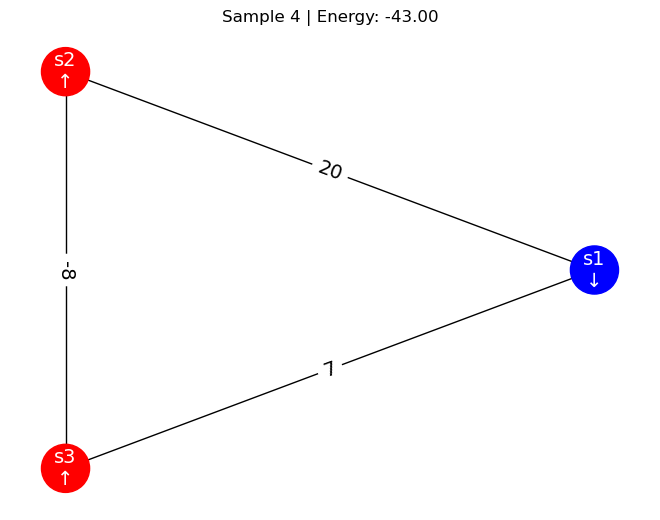

In [8]:
%matplotlib inline
visualize_sample(sampleset_BF, sample_index=4)

## Simulated Annealing
Next, we will use simulated annealing (SA) to solve $\min_{\boldsymbol{s}} H_{\text{Ising}}(\boldsymbol{s})$, i.e., to find the minimum energy state. We perform `num_reads_SA` runs.

In [9]:
num_reads_SA = 100

In [10]:
sampler_SA = SimulatedAnnealingSampler()

In [11]:
sampleset_SA = sampler_SA.sample_ising(h, J, num_reads=num_reads_SA)
sampleset_SA = sampleset_SA.aggregate()

The sample set again contains the values for $s_1, s_2, s_3$ and the corresponding energy $H_{\text{Ising}}(s_1, s_2, s_3)$. In contrast to the brute force sampling, multiple reads can lead to the same result.

In [12]:
print(sampleset_SA)

  s1 s2 s3 energy num_oc.
0 -1 +1 +1  -43.0      85
1 +1 -1 -1  -27.0      15
['SPIN', 2 rows, 100 samples, 3 variables]


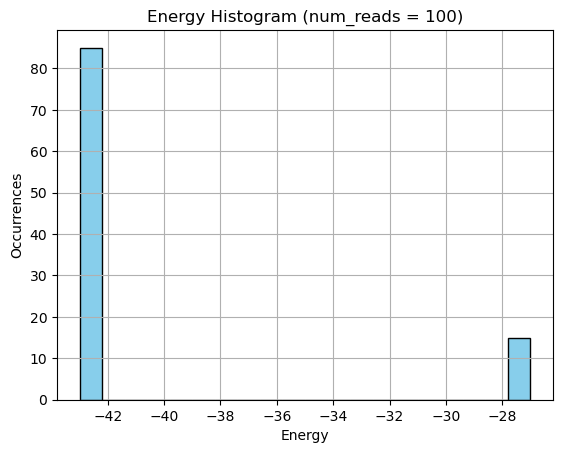

In [13]:
%matplotlib inline
plot_energy_histogram(sampleset_SA)

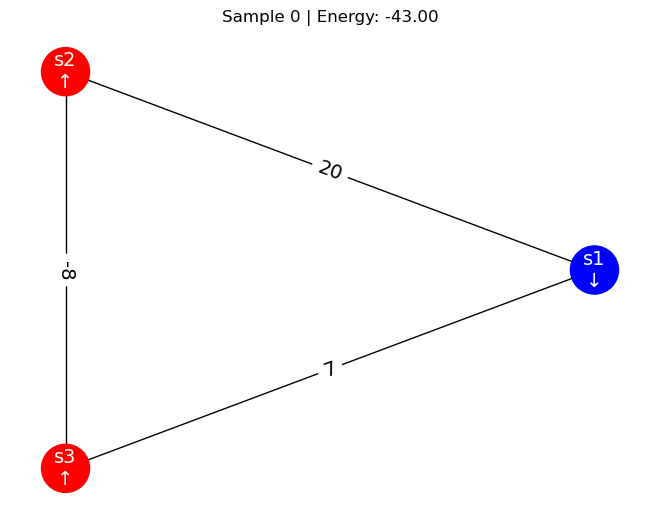

In [14]:
%matplotlib inline
visualize_sample(sampleset_SA, sample_index=0)

## Quantum Annealing
Finally, we use quantum annealing (QA) to sample minimum energy states of $H_{\text{Ising}}(\boldsymbol{s})$, in particular the `DWaveSampler()`. To perform the minor embedding and map the problem graph defined by $h_i$ and $J_{ij}$ to the solver, the `EmbeddingComposite` is used (different embedding strategies are explained [here](https://docs.dwavequantum.com/en/latest/ocean/api_ref_system/composites.html#embedding)). Then, we perform `num_reads_QA` reads using QA.

In [15]:
num_reads_QA = 100

In [16]:
sampler_QA = EmbeddingComposite(DWaveSampler())

In [17]:
sampleset_QA = sampler_QA.sample_ising(h, J, num_reads=num_reads_QA, label='Simple Ising Problem')

The resulting sample set has the same structure as before, and identical results for different reads are collected (cf. `num_oc.` column).
Note that not all results may be the ground state of $H_{\text{Ising}}(\boldsymbol{s})$ due to the probabilistic nature of QA.

In [18]:
print(sampleset_QA)

  s1 s2 s3 energy num_oc. chain_.
0 -1 +1 +1  -43.0      88     0.0
1 +1 -1 -1  -27.0      12     0.0
['SPIN', 2 rows, 100 samples, 3 variables]


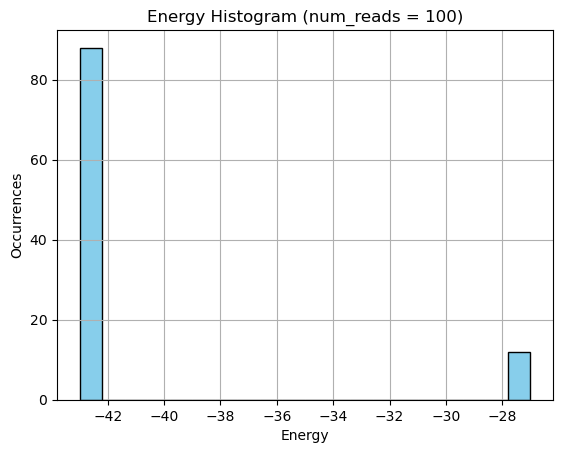

In [19]:
%matplotlib inline
plot_energy_histogram(sampleset_QA)

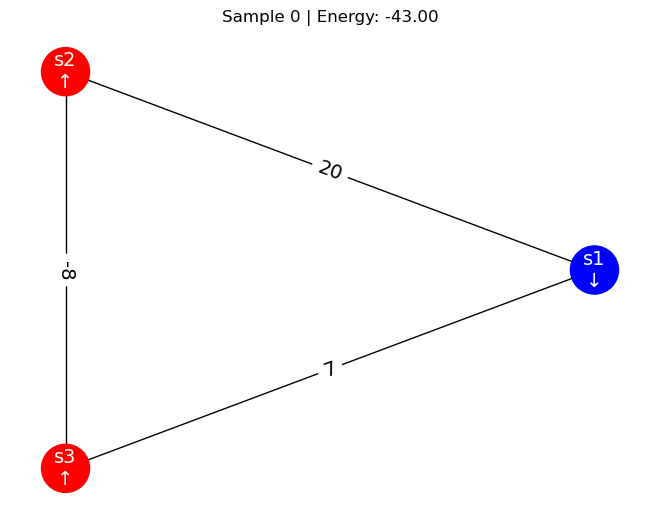

In [20]:
%matplotlib inline
visualize_sample(sampleset_QA, sample_index=0)

### DWave Problem Inspector
The *DWave Problem Inspector* can be used to analyze the returned samples. It shows the underlying problem as an Ising model or QUBO on the left (a mouse-over menu is hidden at the left edge) and the energy histogram on the right. You can also switch to viewing the embedded problem on the QPU (click on the "2" in the top right corner). 

In [21]:
dwave.inspector.show(sampleset_QA)

Serving Inspector on https://juniq.fz-juelich.de/user/fabian.key_at_tuwien.ac.at/zd23d7c295224576abebef788d500602/proxy/18000/?problemId=2dee51fa-34eb-4536-82f9-950e64bda561

'https://juniq.fz-juelich.de/user/fabian.key_at_tuwien.ac.at/zd23d7c295224576abebef788d500602/proxy/18000/?problemId=2dee51fa-34eb-4536-82f9-950e64bda561'

## Potential Tasks
   - Try different values for `num_reads_SA` and `num_reads_QA`
   - Repeat the QA sampling multiple times and keep track of the individual outcomes
   - Compare the energy histograms for SA and QA when `num_reads_SA` equals `num_reads_QA`
   - Extend the problem by introducing additional nodes and/or edges, and study the effect on the embedding